   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
Linear Regression: MAE = 10.49, RMSE = 13.40, R² Score = 0.16
Lasso: MAE = 10.63, RMSE = 13.53, R² Score = 0.15
Ridge: MAE = 10.49, RMSE = 13.40, R² Score = 0.

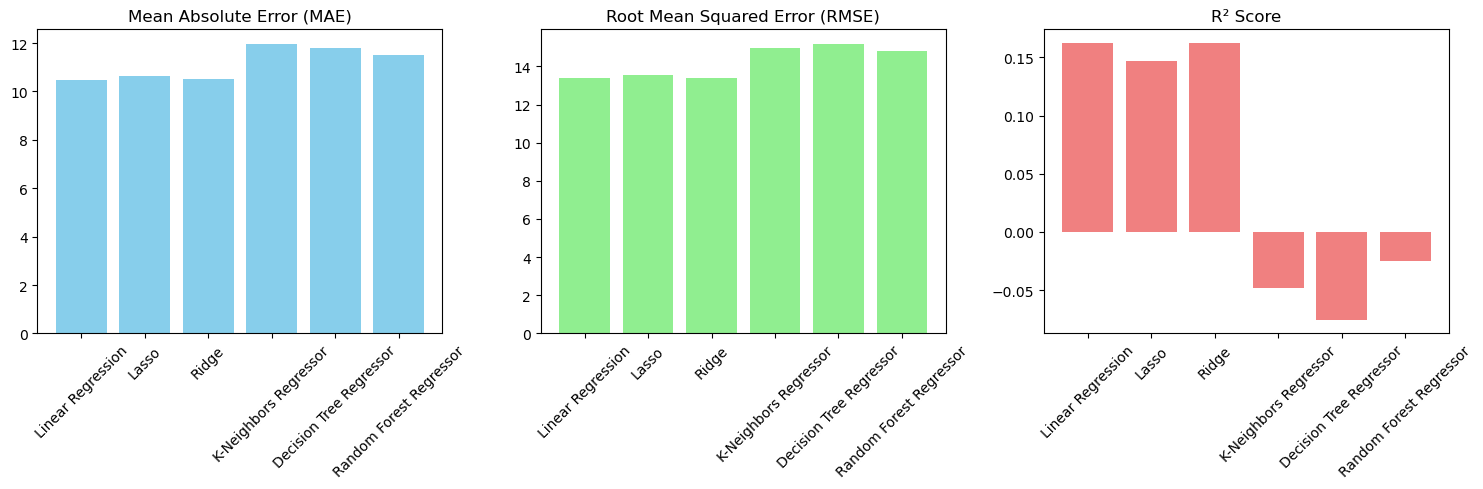

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Lasso Params: {'alpha': 0.01}
Random Forest (Tuned): MAE = 11.10, RMSE = 14.31, R² Score = 0.05
Lasso (Tuned): MAE = 10.50, RMSE = 13.41, R² Score = 0.16
Best Final Model: Lasso (Tuned)
Model saved as 'best_model.pkl'


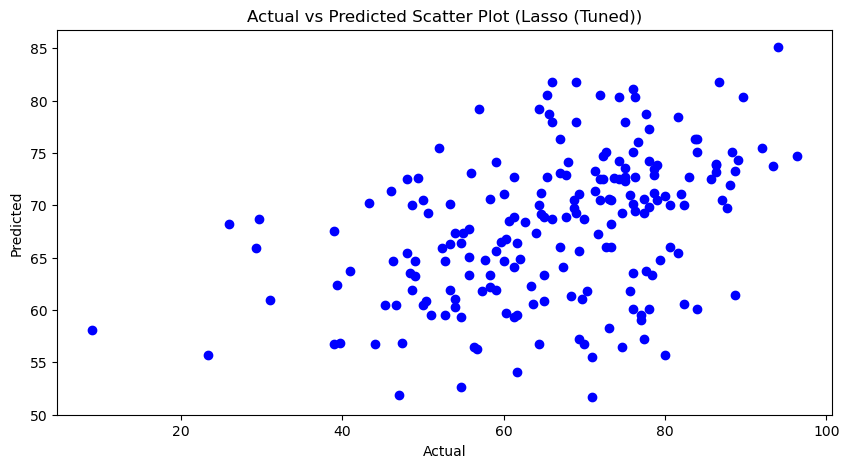

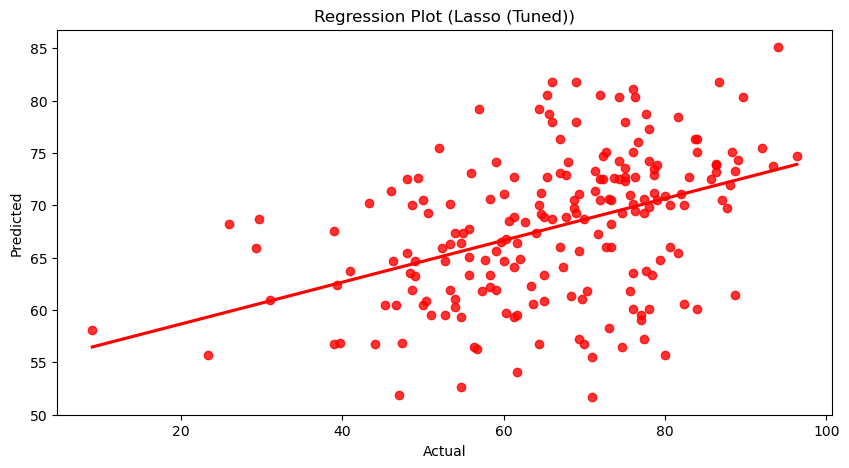

In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('student_data.csv')

# Inspect dataset
print(df.head())

# Feature Engineering: Create 'Performance'
df['Performance'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

# Features and Target
X = df.drop(columns=['math score', 'reading score', 'writing score', 'Performance'])
y = df['Performance']

# Categorical and Numerical columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessor
preprocessor = ColumnTransformer([
    ("OneHotEncoder", OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ("StandardScaler", StandardScaler(), num_cols)
])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit-transform Train, transform Test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Base models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1),
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R² Score": r2}
    print(f"{name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² Score = {r2:.2f}")


model_names = list(results.keys())
mae_scores = [results[m]["MAE"] for m in model_names]
rmse_scores = [results[m]["RMSE"] for m in model_names]
r2_scores = [results[m]["R² Score"] for m in model_names]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.title('Mean Absolute Error (MAE)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(model_names, rmse_scores, color='lightgreen')
plt.title('Root Mean Squared Error (RMSE)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(model_names, r2_scores, color='lightcoral')
plt.title('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Random Forest Tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                              param_grid_rf,
                              cv=5,
                              scoring='r2',
                              n_jobs=-1,
                              verbose=1)

grid_search_rf.fit(X_train_transformed, y_train)
best_rf_model = grid_search_rf.best_estimator_

print("Best Random Forest Params:", grid_search_rf.best_params_)

# Lasso Tuning
param_grid_lasso = {
    'alpha': [0.01, 0.1, 1, 10]
}

grid_search_lasso = GridSearchCV(Lasso(),
                                 param_grid_lasso,
                                 cv=5,
                                 scoring='r2',
                                 n_jobs=-1,
                                 verbose=1)

grid_search_lasso.fit(X_train_transformed, y_train)
best_lasso_model = grid_search_lasso.best_estimator_

print("Best Lasso Params:", grid_search_lasso.best_params_)


# Compare tuned models
tuned_models = {
    "Random Forest (Tuned)": best_rf_model,
    "Lasso (Tuned)": best_lasso_model
}

final_results = {}

for name, model in tuned_models.items():
    y_pred = model.predict(X_test_transformed)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    final_results[name] = {"MAE": mae, "RMSE": rmse, "R² Score": r2}
    print(f"{name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² Score = {r2:.2f}")

# Choose best final model
best_final_model_name = max(final_results, key=lambda m: final_results[m]["R² Score"])
best_final_model = tuned_models[best_final_model_name]

print(f"Best Final Model: {best_final_model_name}")


# Save model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_final_model, f)

print("Model saved as 'best_model.pkl'")


# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, best_final_model.predict(X_test_transformed), color="blue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted Scatter Plot ({best_final_model_name})")
plt.show()

# Regression plot
plt.figure(figsize=(10, 5))
sns.regplot(x=y_test, y=best_final_model.predict(X_test_transformed), ci=None, color="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Regression Plot ({best_final_model_name})")
plt.show()
